In [3]:
%matplotlib ipympl
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np

In [8]:
print( 'ipywidgets version: ', widgets.__version__ )
print( 'numpy version     : ', np.__version__)

ipywidgets version:  8.0.4
numpy version     :  1.20.3


In [5]:
# define space invader
space_invader = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # row_00
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # row_01
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # row_02
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # row_03
                          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],  # row_04
                          [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],  # row_05
                          [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],  # row_06
                          [0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0],  # row_07
                          [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],  # row_08
                          [0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0],  # row_09
                          [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],  # row_10
                          [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0],  # row_11
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # row_12
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # row_13
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # row_14
                          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]) # row_15

Nx, Ny = space_invader.shape[0], space_invader.shape[1]

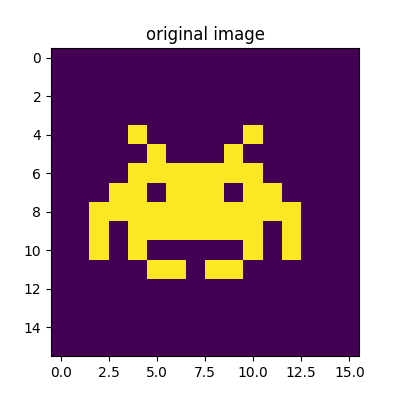

In [11]:
# plot the original (non-rotated) image
fig1 = plt.figure( figsize=(4,4) )   # (width, height) in inches
ax1_1= fig1.add_subplot( 1,1,1 )      # rows, cols, plotnumber

img  = ax1_1.imshow(space_invader)
ax1_1.set_title ('original image')
plt.show()

# Rotation via Matrices

$
\begin{pmatrix} x'\\ y' \end{pmatrix} =
\begin{pmatrix}
\cos\alpha  & \sin\theta\\
-\sin\alpha & \cos\theta\\
\end{pmatrix}
\begin{pmatrix} x\\y \end{pmatrix}
$

\begin{align}
x' &= x\cos\alpha + y\sin\alpha \\
y' &= -x\sin\alpha + y\cos\alpha
\end{align}

Problem: aliasing (sin and cos give real numbers we need to round back to integers, which can lead sometimes to numbers being round to the same coordinate on the grid twice or not at all)

In [12]:
def rotate_via_rotMatrix(coords_in, angle_in_degree, rot_axis='z', rot_center=np.array([0,0])):
    alpha = np.radians(angle_in_degree)
    """
    Rotate coordinate vector using the rotation matrix.
    """
    
    # transform coordinate system such that rotation center is origin
    coords_in[0] -= rot_center[0]
    coords_in[1] -= rot_center[1]
    
    # define rotation matrix
    if rot_axis == 'z':
        rot_matrix = np.matrix([[np.cos(alpha), -np.sin(alpha)],
                                [np.sin(alpha), np.cos(alpha) ]])
        
    coords_new = rot_matrix * np.array([[coords_in[0]],
                                        [coords_in[1]]])
    
    # transform coordinate system back to original system
    coords_new = np.array( [round(coords_new[0,0] + rot_center[0]), 
                            round(coords_new[1,0] + rot_center[1])] )
    
    return coords_new

# Rotation via Shearing

Introduced by Alan W. Paeth in 1986 [1], a rotation can also be performed by 3 consecutive shear operations. Assuming that we have a 2D image, we need 2 quantities to perform the shearing operations: $k_x$ and $k_y$, which represent the shear operation in $x$ and $y$ direction, respectively. Let's assume further that we want to rotate our image by the angle $\alpha$, then $k_x$ and $k_y$ are calculated as follows
\begin{align}
k_x &= -\tan(\alpha/2)\\
k_y &= \sin(\alpha).
\end{align}
The new coordinates $x'$ and $y'$ are then calculated with the following three steps
\begin{align}
x' &= x + k_x\cdot y\\
y' &= y + k_y\cdot x'\\
x' &= x' + k_x\cdot y'
\end{align}
This corresponds to a rotation around the origin $(0,0)$. To rotate around a different coordinate, we simply perform a coordinate transformation before the shearing operations, and a back-tranformation after the shearing operations.

Since there are three separate shearing operations, and each shearing operation is just in one direction and conformal in area, there will be no "gaps"/"holes" appearing, no aliasing. Also note that this is memory saving as only one plane is treated at once.

The shearing operation can also we written in matrix form:

$
\begin{pmatrix}x'\\y'\end{pmatrix}
= \begin{pmatrix} 1 & -\tan\alpha/2 \\ 0 & 1\end{pmatrix}
  \begin{pmatrix} 1 & 0 \\ \sin\alpha & 1\end{pmatrix}
  \begin{pmatrix} 1 & -\tan\alpha/2 \\ 0 & 1\end{pmatrix}
  \begin{pmatrix}x\\y\end{pmatrix}
$

Note: for illustration purposes it might be nice to show how doing the three consecutive shears look like.

[1] https://doi.org/10.20380/GI1986.15

In [13]:
def rotate_via_shearing(coords_in, angle_in_degree, rot_axis='z', rot_center=np.array([0,0])):
    """
    Rotate coordinate vector using the shearing method.
    """
    
    alpha = np.radians(angle_in_degree)
    
    # transform coordinate system such that rotation center is origin
    coords_in[0] -= rot_center[0]
    coords_in[1] -= rot_center[1]
    
    # translations
    shear_1 = np.tan(alpha/2.)
    shear_2 = -np.sin(alpha)
    shear_3 = np.tan(alpha/2.)
    
    if rot_axis =='z':
        y_new = coords_in[1] + round(shear_1*coords_in[0])
        x_new = coords_in[0] + round(shear_2*y_new)
        y_new = y_new + round(shear_3*x_new)
        
    # transform coordinate system back to original system
    coords_new = np.array( [[x_new + rot_center[0]], [y_new + rot_center[1]]] )
        
    return coords_new

In [14]:
def check_boundaries(coords_new, coords_min, coords_max):
    """
    Check if the new (rotated) coordinate vector is still within the grid boundaries.
    """
    # check x boundaries
    if coords_new[0] < coords_min[0]: return False
    elif coords_new[0] >= coords_max[0]: return False
    # check y boundaries
    if coords_new[1] < coords_min[1]: return False
    elif coords_new[1] >= coords_max[1]: return False

    return True

In [15]:
def rotate_arr_via_rotMatrix( arr_in, angle_in_degrees,
                              rot_axis='z', rot_center=np.array([0,0])):
    """
    Rotate full array using the rotation matrix.
    """

    Ny, Ny = arr_in.shape[0], arr_in.shape[1]
    
    arr_rotated = np.zeros( (Nx,Ny) )

    for xx in range(Nx):
        for yy in range(Ny):
            if arr_in[xx,yy] > 0:
                # rotate via rotation matrix
                coords_new = rotate_via_rotMatrix( np.array([xx,yy]), angle_in_degrees, 
                                                   rot_axis='z', 
                                                   rot_center=rot_center )
                if check_boundaries(coords_new, np.array([0,0]), np.array([Nx, Ny])):
                    arr_rotated[ coords_new[0], coords_new[1] ] = 1
                
    return arr_rotated

In [16]:
def rotate_arr_via_shearing( arr_in, angle_in_degrees, 
                             rot_axis='z', rot_center=np.array([0,0]) ):
    """
    Rotate full array using the shearing method.
    """
    
    Ny, Ny = arr_in.shape[0], arr_in.shape[1]
        
    arr_rotated = np.zeros( (Nx,Ny) )

    for xx in range(Nx):
        for yy in range(Ny):
            if arr_in[xx,yy] > 0:
                # rotate via rotation matrix
                coords_new = rotate_via_shearing( np.array([xx,yy]), angle_in_degrees, 
                                                  rot_axis='z', 
                                                  rot_center=rot_center )
                if check_boundaries(coords_new, np.array([0,0]), np.array([Nx, Ny])):
                    arr_rotated[ coords_new[0], coords_new[1] ] = 1
                
    return arr_rotated

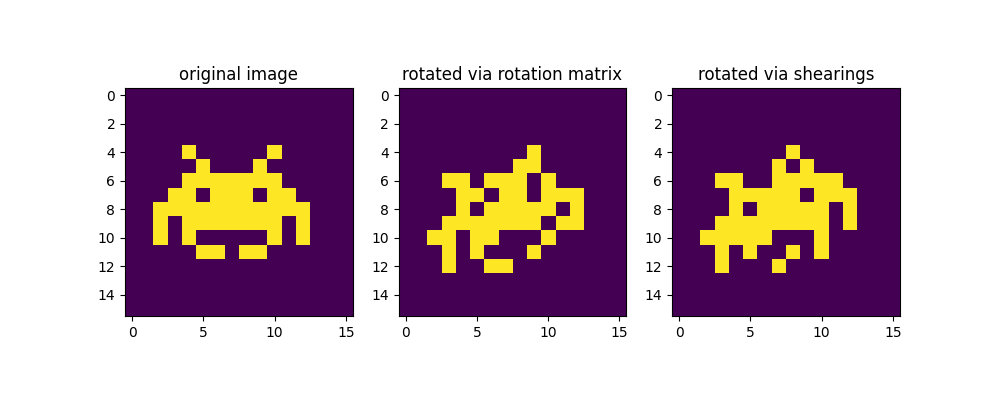

In [28]:
angle_in_degrees = 20
rot_center = np.array( [round(Nx/2), round(Ny/2)] )

space_invader_rotated1 = rotate_arr_via_rotMatrix( space_invader, angle_in_degrees, rot_center=rot_center )
space_invader_rotated2 = rotate_arr_via_shearing( space_invader, angle_in_degrees, rot_center=rot_center )

fig2 = plt.figure( figsize=(10,4) )   # (width, height) in inches

# original image
ax2_1 = fig2.add_subplot( 1,3,1 )      # rows, cols, plotnumber
img_original = ax2_1.imshow(space_invader)
ax2_1.set_title ('original image')

# rotated via rotation matrix
ax2_2  = fig2.add_subplot( 1,3,2 )      # rows, cols, plotnumber
img_rotated_shear = ax2_2.imshow(space_invader_rotated1)
ax2_2.set_title ('rotated via rotation matrix')

# rotated via rotation matrix
ax2_3  = fig2.add_subplot( 1,3,3 )      # rows, cols, plotnumber
img_rotated_shear = ax2_3.imshow(space_invader_rotated2)
ax2_3.set_title ('rotated via shearings')

plt.show()

In [24]:
def plot_image(ax, arr_in, angle_in_degrees=0, rot='shear', rot_center=np.array([0,0])):
    if rot == 'shear':
        img_rot = rotate_arr_via_shearing( arr_in, angle_in_degrees, rot_center=rot_center )
    elif rot == 'matrix':
        img_rot = rotate_arr_via_rotMatrix( arr_in, angle_in_degrees, rot_center=rot_center )
    img = ax.imshow(img_rot)

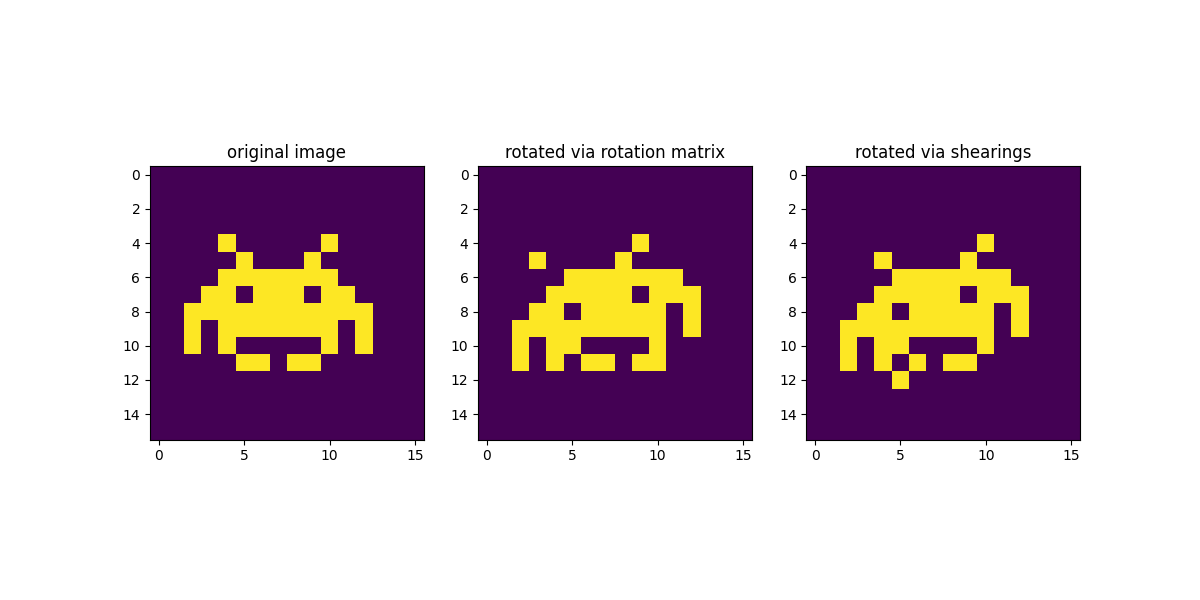

IntSlider(value=0, max=90)

In [27]:
angle_in_degrees = 10
rot_center = np.array( [round(Nx/2), round(Ny/2)] )

fig3 = plt.figure( figsize=(12,6) )   # (width, height) in inches

# original image
ax3_1 = fig3.add_subplot( 1,3,1 )      # rows, cols, plotnumber
# rotated via rotation matrix
ax3_2 = fig3.add_subplot( 1,3,2 )      # rows, cols, plotnumber
# rotated via rotation matrix
ax3_3 = fig3.add_subplot( 1,3,3 )      # rows, cols, plotnumber

img_original = ax3_1.imshow(space_invader)
ax3_1.set_title ('original image')

plot_image(ax3_2, space_invader, angle_in_degrees=angle_in_degrees, rot='matrix', rot_center=rot_center)
ax3_2.set_title ('rotated via rotation matrix')

plot_image(ax3_3, space_invader, angle_in_degrees=angle_in_degrees, rot='shear', rot_center=rot_center)
ax3_3.set_title ('rotated via shearings')

plt.show()

slider_angle = widgets.IntSlider(value=0, min=0, max=90, step=1)

# callback function for the slider widget
def handle_slider_change(change):
    # update rotation via matrix 
    plot_image(ax3_2, space_invader, angle_in_degrees=change.new, rot='matrix', rot_center=rot_center)
    # update rotation via shear
    plot_image(ax3_3, space_invader, angle_in_degrees=change.new, rot='shear', rot_center=rot_center)
    fig3.canvas.draw()

# connect handle_slider_change function to slider widget using the .observe() method, observing changes in value attribute
slider_angle.observe(handle_slider_change, 'value')
slider_angle